In [1]:
# load packages
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import os
from datetime import datetime
from sklearn.datasets import make_spd_matrix
from torch.utils.data import random_split, DataLoader
from scipy.stats import qmc
import time
from scipy.special import hankel1


In [2]:
def u_boundary(x, y , k=3):
    kx = k * x  # x es la primera componente
    phi_inc = np.exp(1j * kx)
    theta = np.atan2(y, x)
    return np.cos(theta) * -1j * k * phi_inc

# Crear malla regular en el dominio [0,1]x[0,1]
n_samples = 100
x = np.linspace(-1, 1, n_samples)
y = np.linspace(-1, 1, n_samples)
X_grid, Y_grid = np.meshgrid(x, y) 
# Calcular la función de frontera
Z_grid = u_boundary(X_grid, Y_grid)

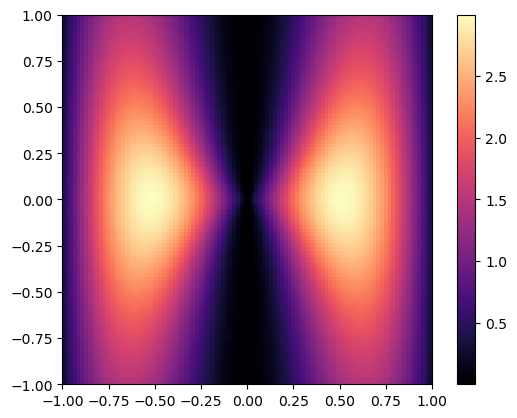

In [3]:
plt.imshow(Z_grid.real, cmap='magma', extent=(-1, 1, -1, 1), origin='lower')
plt.colorbar()
plt.show()


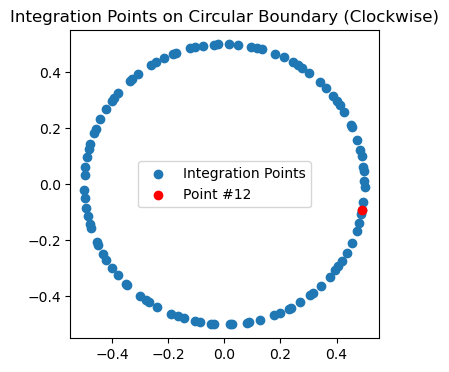

In [4]:
def integration_points_circle(n_int, R=0.3, epsilon=0.2):
    # Ángulos distribuidos uniformemente en sentido horario
    angles = torch.linspace(0, -2 * torch.pi, n_int + 1)[:-1]
    
    # Pequeño desplazamiento aleatorio para evitar puntos perfectamente uniformes
    angles += torch.rand(angles.shape) * (-2 * torch.pi / n_int) + np.random.rand() * 0.05

    # Radio del contorno exterior
    radius = R + epsilon

    # Coordenadas x, y en la circunferencia
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)

    # Tensor de puntos con gradientes habilitados
    x_int = torch.stack((x, y), dim=1).requires_grad_(True)

    return x_int

# Generar y graficar puntos
x_int = integration_points_circle(100, R=0.3, epsilon=0.2)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')
plt.scatter(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy(), label="Integration Points")
plt.scatter(x_int[3, 0].detach().numpy(), x_int[3, 1].detach().numpy(), c='red', label="Point #12")
plt.legend()
plt.title("Integration Points on Circular Boundary (Clockwise)")
plt.show()

In [5]:
def outer_normal_circle(x):
    """
    Devuelve los vectores normales exteriores en los puntos x sobre el borde de un círculo.
    
    Parámetros:
    x: tensor de tamaño (N, 2), con puntos sobre el borde del círculo
    
    Retorna:
    normals: tensor de tamaño (N, 2), con los vectores normales exteriores unitarios
    """
    center = torch.tensor([0.0, 0.0], dtype=x.dtype, device=x.device).view(1, 2)
    r = x - center
    r_norm = torch.norm(r, dim=1, keepdim=True)
    normals = r / r_norm  # Vector unitario radial (normal exterior)
    return normals

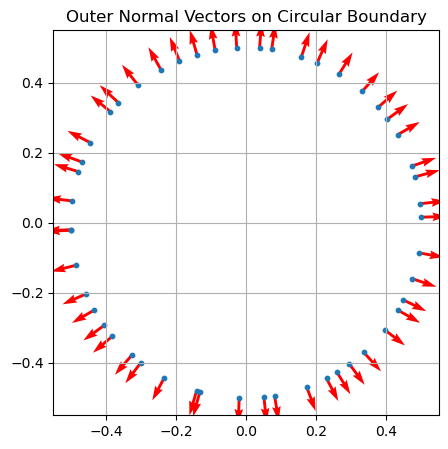

In [6]:
# Generar puntos
x_int = integration_points_circle(50, R=0.3, epsilon=0.2)

# Calcular normales
normals = outer_normal_circle(x_int)

# Visualizar puntos y vectores normales
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
x_np = x_int.detach().numpy()
n_np = normals.detach().numpy()
plt.quiver(x_np[:, 0], x_np[:, 1], n_np[:, 0], n_np[:, 1], scale=15, color='red')
plt.scatter(x_np[:, 0], x_np[:, 1], s=10)
plt.title("Outer Normal Vectors on Circular Boundary")
plt.grid(True)
plt.show()

In [7]:
print(torch.__version__)
print(hasattr(torch.special, 'hankel1'))

2.7.0+cu126
False


In [39]:
def fundamental_solution_helmholtz_real_imag(x, y, k):
    delta = x - y
    r = torch.norm(delta, dim=1)
    r = torch.where(r < 1e-10, torch.full_like(r, 1e-10), r)

    kr = k * r

    J0 = torch.special.bessel_j0(kr)
    Y0 = torch.special.bessel_y0(kr)

    phi_real = (1.0 / 4.0) * J0.view(-1, 1)
    phi_imag = (1.0 / 4.0) * Y0.view(-1, 1)

    return phi_real, phi_imag

 

def gradient_fundamental_helmholtz_real_imag(x, y, k):
    delta = x - y
    r = torch.norm(delta, dim=1).detach().cpu().numpy()
    delta_np = delta.detach().cpu().numpy()

    H1 = hankel1(1, k * r)
    coef = (-k / 4) * H1 / r
    coef[r == 0] = 0.0  # avoid division by zero

    coef_real = torch.tensor(coef.real, dtype=torch.float32, device=x.device).view(-1, 1)
    coef_imag = torch.tensor(coef.imag, dtype=torch.float32, device=x.device).view(-1, 1)

    grad_real = coef_real * delta
    grad_imag = coef_imag * delta

    return grad_real, grad_imag

In [46]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution_helmholtz_real_imag(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)

    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental_helmholtz_real_imag(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

In [56]:
class FCNN(nn.Module):
    def __init__(self, N_input, N_output=2, N_hidden=64, N_layers=4, n_int=100):
        super().__init__()
        activation = nn.Tanh
        self.n_int = n_int

        self.fc_start = nn.Sequential(
            nn.Linear(N_input, N_hidden),
            activation()
        )

        self.fc_hidden = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_hidden, N_hidden), activation())
            for _ in range(N_layers - 1)
        ])

        self.fc_end = nn.Linear(N_hidden, N_output)  # real and imag

    def forward(self, x):
        epsilon = 0.1
        x_scaled = 2 * (x - torch.tensor([-1 - epsilon, -1 - epsilon], dtype=x.dtype)) / \
                   (torch.tensor([1 + epsilon, 1 + epsilon], dtype=x.dtype) - torch.tensor([-1 - epsilon, -1 - epsilon], dtype=x.dtype)) - 1

        x = self.fc_start(x_scaled)
        x = self.fc_hidden(x)
        u = self.fc_end(x)
        return u  # shape (N, 2)

    def resample(self):
        self.x_int = integration_points_circle(self.n_int, R=1.0, epsilon=0.2)
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')

    def calc_potentials_inside(self, x, k=5.0):
        y = self.x_int
        normal_y = outer_normal_circle(y)
        h_y = self(y)
        h_real, h_imag = h_y[:, 0:1], h_y[:, 1:2]

        # Derivatives of h_real and h_imag
        dh_real_dy = torch.autograd.grad(h_real, y, grad_outputs=torch.ones_like(h_real), create_graph=True)[0]
        dh_imag_dy = torch.autograd.grad(h_imag, y, grad_outputs=torch.ones_like(h_imag), create_graph=True)[0]
        dh_real_dn = torch.sum(dh_real_dy * normal_y, dim=1, keepdim=True)
        dh_imag_dn = torch.sum(dh_imag_dy * normal_y, dim=1, keepdim=True)

        # Fundamental solution (real and imag)
        G_real, G_imag = fundamental_solution_helmholtz_real_imag(x.repeat(y.shape[0], 1), y)

        # Single layer
        single_real = torch.mean(G_real * dh_real_dn - G_imag * dh_imag_dn)
        single_imag = torch.mean(G_real * dh_imag_dn + G_imag * dh_real_dn)

        # Gradient of Green function (real and imag)
        dG_real, dG_imag = gradient_fundamental_helmholtz_real_imag(x.repeat(y.shape[0], 1), y)
        dG_real_dn = torch.sum(dG_real * normal_y, dim=1, keepdim=True)
        dG_imag_dn = torch.sum(dG_imag * normal_y, dim=1, keepdim=True)

        # Double layer
        double_real = torch.mean(dG_real_dn * h_real - dG_imag_dn * h_imag)
        double_imag = torch.mean(dG_real_dn * h_imag + dG_imag_dn * h_real)

        return torch.stack([single_real, single_imag]), torch.stack([double_real, double_imag])

    def predict_u_inside(self, x):
        single_layer, double_layer = self.vmapped_potential_inside(x)
        u_real = single_layer[:, 0] - double_layer[:, 0]
        u_imag = single_layer[:, 1] - double_layer[:, 1]
        return torch.stack([u_real, u_imag], dim=1)  # shape (N, 2)

In [57]:
def initialise_pibi(lr, n_int):

    # define number of neurons in each layer type
    N_input  = 2
    N_output = 2
    N_hidden = 64 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers, n_int)
    
    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error
    
    return pibi, optimiser, mse_loss

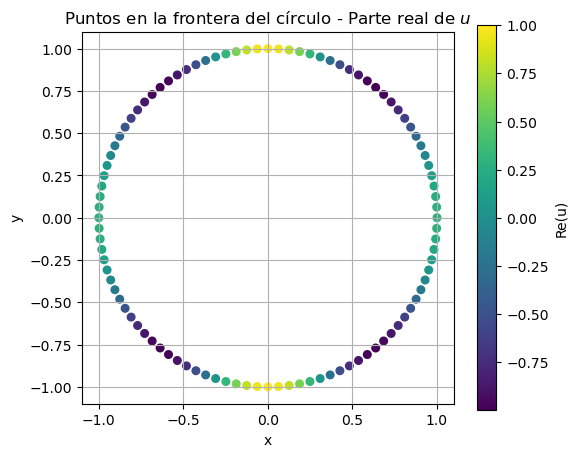

In [58]:
# Número de puntos sobre la frontera
n_boundary = 100
radius = 1.0

# Puntos sobre el círculo
theta = np.linspace(0, 2*np.pi, n_boundary, endpoint=False)
x_boundary = radius * np.cos(theta)
y_boundary = radius * np.sin(theta)

# Función analítica definida por el usuario
def u_boundary(x, y, k=5.0):
    return np.exp(1j * k * x)  # por ejemplo, una onda plana

# Evaluar función
U_complex = u_boundary(x_boundary, y_boundary)
U_real = np.real(U_complex)
U_imag = np.imag(U_complex)

# Graficar puntos coloreados por parte real
plt.figure(figsize=(6, 5))
sc = plt.scatter(x_boundary, y_boundary, c=U_real, cmap='viridis', s=30)
plt.colorbar(sc, label='Re(u)')
plt.gca().set_aspect('equal')
plt.title('Puntos en la frontera del círculo - Parte real de $u$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [59]:
def train_pibi(iterations, pibi, optimiser, mse_loss, data, data_n, n_samples, n_int, time_now, show_plots):
    # store loss values
    loss_values = []

    for epoch in range(iterations):
        optimiser.zero_grad()
        pibi.resample()

        # Forward pass
        u_pred = pibi.predict_u_inside(data[:, 0:2])  # Output shape: (N, 2) → [real, imag]
        u_real = u_pred[:, 0].view(-1, 1)
        u_imag = u_pred[:, 1].view(-1, 1)

        # Split target data into real and imaginary parts
        u_real_target = data[:, -2].view(-1, 1)
        u_imag_target = data[:, -1].view(-1, 1)

        # Compute losses separately
        loss_real = mse_loss(u_real, u_real_target)
        loss_imag = mse_loss(u_imag, u_imag_target)

        # Total loss: sum of both
        loss = loss_real + loss_imag
        loss_values.append(loss.item())

        # Backpropagation
        loss.backward()
        optimiser.step()

        print(f"Epoch {epoch}: Loss = {loss.item():.6f} (Real = {loss_real.item():.6f}, Imag = {loss_imag.item():.6f})")

    return pibi, loss_values

In [60]:
# --- Hiperparámetros y tamaño ---
n_samples = 200
n_int = 200
radius = 1.0
show_plots = True

# --- Latin Hypercube Sampling (LHS) en el dominio [-1,1] x [-1,1] ---
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_samples = lhs_sampler.random(n=n_samples)
lhs_scaled = qmc.scale(lhs_samples, [-1, -1], [1, 1])

# --- Evaluar solución analítica COMPLEJA en puntos LHS ---
X_lhs, Y_lhs = lhs_scaled[:, 0], lhs_scaled[:, 1]
U_complex = u_boundary(X_lhs, Y_lhs)  # <- debe retornar un array complejo: shape (n_samples,)

# Separar parte real e imaginaria
U_real = np.real(U_complex)
U_imag = np.imag(U_complex)

# Combinar en matriz (x, y, real(u), imag(u))
XU_lhs = np.column_stack((X_lhs, Y_lhs, U_real, U_imag))  # shape (n_samples, 4)

# --- También se puede construir una malla regular (opcional) ---
x = np.linspace(-1, 1, n_samples)
y = np.linspace(-1, 1, n_samples)
X_grid, Y_grid = np.meshgrid(x, y)
U_grid_complex = u_boundary(X_grid, Y_grid)

XU_grid = np.column_stack((
    X_grid.ravel(),
    Y_grid.ravel(),
    np.real(U_grid_complex).ravel(),
    np.imag(U_grid_complex).ravel()
))

In [61]:
# Convertir a tensores de PyTorch
data = torch.tensor(XU_lhs, dtype=torch.float64)
data_ = torch.tensor(XU_grid, dtype=torch.float64)  # opcional para visualización

# Inicializar red y optimizador
lr = 0.001
pibi, optimiser, mse_loss = initialise_pibi(lr, n_int)

# Ejecutar entrenamiento
iterations = 10_001
time_now = datetime.now().strftime("%Y%m%d_%H%M")
pibi, loss_values = train_pibi(iterations, pibi, optimiser, mse_loss, data, 00, n_samples, n_int, time_now, show_plots)


AttributeError: module 'torch.special' has no attribute 'j0'

In [53]:
def fundamental_solution_helmholtz_real_imag(x, y, k=3):
    delta = x - y
    r = torch.norm(delta, dim=1)

    # Evitar singularidad
    r = torch.where(r < 1e-10, torch.full_like(r, 1e-10), r)

    kr = k * r
    J0 = torch.special.j0(kr)
    Y0 = torch.special.y0(kr)

    phi_real = (1 / 4) * J0
    phi_imag = (1 / 4) * Y0

    return torch.stack((phi_real, phi_imag), dim=1)

In [54]:
# TEST
x = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float64)
y = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float64)

result = fundamental_solution_helmholtz_real_imag(x, y, k=3)
print("Resultado (real, imag):")
print(result)

AttributeError: module 'torch.special' has no attribute 'j0'

In [55]:
torch.special.bessel_j0(torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64))
torch.special.bessel_y0(torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64))
# TEST


tensor([0.0883, 0.5104, 0.3769], dtype=torch.float64)